# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

Minimal vocab size for 90% coverage: 10483


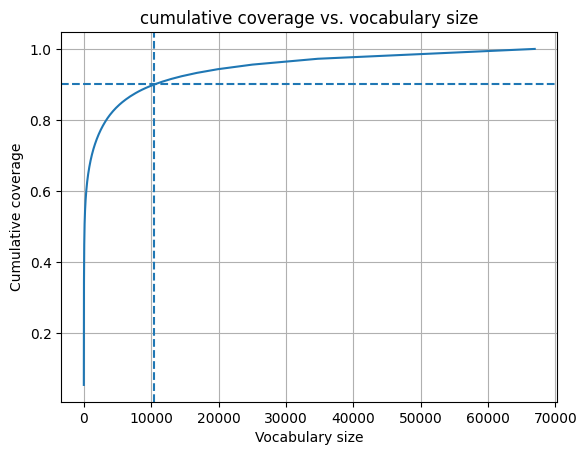

In [3]:
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import bisect

BROWN_DIR = Path("/kaggle/input/datasets/organizations/nltkdata/brown-corpus/brown/brown")

cnt = Counter()
for p in BROWN_DIR.iterdir():
    if not p.is_file(): 
        continue
    if p.name.upper() in {"README", "CONTENTS", "CATS.TXT"}:
        continue
    cnt.update(p.read_text(encoding="latin-1").split())

freqs = [f for _, f in cnt.most_common()]
total = sum(freqs)

cum = []
s = 0
for f in freqs:
    s += f
    cum.append(s / total)

k90 = bisect.bisect_left(cum, 0.9) + 1

print("Minimal vocab size for 90% coverage:", k90)

plt.plot(range(1, len(cum) + 1), cum)
plt.axhline(0.9, linestyle="--")
plt.axvline(k90, linestyle="--")
plt.xlabel("Vocabulary size")
plt.ylabel("Cumulative coverage")
plt.title("cumulative coverage vs. vocabulary size")
plt.grid(True)
plt.show()

**Why the coverage slows down the increase as the vocabulary size increases?**

The most common words cover most of the text, so coverage grows fast at first. Later each new rare word adds almost nothing — so the curve significantly slows down growth: bigger vocabs add rarer words.

**Which empirical law explains the slowing down increase of the coverage?**

This is explained by Zipf's law, which states that word frequency is approximately inversely proportional to its rank. Small number of common words cover most tokens, and many rare words contribute very little to the total coverage.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [ ]:
from collections import defaultdict
from typing import Dict, List, Tuple

class BPETokenizer:
    def __init__(self, vocab_size: int, end_of_word: str = "</w>") -> None:
        """Initialize the tokenizer.

        vocab_size: int
            Target vocabulary size (number of unique subword units including
            characters and merged symbols).
        end_of_word: str
            Special end-of-word marker appended during training to indicate
            word boundaries.
        """
        self.vocab_size = vocab_size
        self.end_of_word = end_of_word
        # Learned merges in order
        self.merges: List[Tuple[str, str]] = []
        # Fast lookup: pair -> rank (index in merges list)
        self.merge_ranks: Dict[Tuple[str, str], int] = {}

    @staticmethod
    def _get_stats(word_sequences: Dict[Tuple[str, ...], int]) -> Dict[Tuple[str, str], int]:
        """Compute frequencies of all adjacent symbol pairs.

        word_sequences: dict
            Keys are tuples of symbols (subwords / characters) representing
            words, values are word frequencies in the corpus.
        """
        stats: Dict[Tuple[str, str], int] = defaultdict(int)
        for symbols, freq in word_sequences.items():
            if len(symbols) < 2:
                continue
            for i in range(len(symbols) - 1):
                pair = (symbols[i], symbols[i + 1])
                stats[pair] += freq
        return stats

    @staticmethod
    def _merge_pair(
        pair: Tuple[str, str],
        word_sequences: Dict[Tuple[str, ...], int],
    ) -> Dict[Tuple[str, ...], int]:
        """Apply a single merge operation to the whole corpus representation.
        """
        a, b = pair
        new_corpus: Dict[Tuple[str, ...], int] = {}
        for symbols, freq in word_sequences.items():
            new_symbols: List[str] = []
            i = 0
            while i < len(symbols):
                if i < len(symbols) - 1 and symbols[i] == a and symbols[i + 1] == b:
                    new_symbols.append(a + b)
                    i += 2
                else:
                    new_symbols.append(symbols[i])
                    i += 1
            new_corpus[tuple(new_symbols)] = freq
        return new_corpus

    def train(self, texts: List[str]) -> None:
        """Learn BPE merges from a list of training sentences.
        """
        # Build word frequency dictionary
        word_freq: Counter = Counter()
        for line in texts:
            for word in line.strip().split():
                if word:
                    word_freq[word] += 1

        # Represent each word as a tuple of characters + end-of-word marker
        word_sequences: Dict[Tuple[str, ...], int] = {}
        for word, freq in word_freq.items():
            symbols = tuple(list(word) + [self.end_of_word])
            word_sequences[symbols] = freq

        # Initial vocabulary: all unique symbols
        vocab = {sym for seq in word_sequences for sym in seq}

        # Learn merges until desired vocabulary size is reached or no pairs remain
        while len(vocab) < self.vocab_size:
            stats = self._get_stats(word_sequences)
            if not stats:
                break

            # Most frequent pair
            best_pair = max(stats.items(), key=lambda x: x[1])[0]
            if stats[best_pair] <= 0:
                break

            # Apply merge
            word_sequences = self._merge_pair(best_pair, word_sequences)

            # Record merge and update rank table
            self.merges.append(best_pair)
            self.merge_ranks[best_pair] = len(self.merges) - 1

            # Add new symbol to vocabulary
            new_symbol = best_pair[0] + best_pair[1]
            vocab.add(new_symbol)

    def _apply_merges_to_word(self, word: str) -> List[str]:
        """Apply learned merges to a single word and return BPE tokens."""
        # Start from characters + end-of-word marker
        symbols: List[str] = list(word) + [self.end_of_word]

        if not self.merge_ranks:
            # If not trained, fall back to character-level tokens
            return [w for w in word] if word else []

        while True:
            # Collect all adjacent pairs in the current symbol sequence
            pairs = [(symbols[i], symbols[i + 1]) for i in range(len(symbols) - 1)]

            # Find the pair with the smallest rank among those present
            best_pair = None
            best_rank = None
            for p in pairs:
                if p in self.merge_ranks:
                    r = self.merge_ranks[p]
                    if best_rank is None or r < best_rank:
                        best_rank = r
                        best_pair = p

            if best_pair is None:
                break  # no more merges applicable

            # Merge all occurrences of best_pair in this word
            new_symbols: List[str] = []
            i = 0
            a, b = best_pair
            while i < len(symbols):
                if i < len(symbols) - 1 and symbols[i] == a and symbols[i + 1] == b:
                    new_symbols.append(a + b)
                    i += 2
                else:
                    new_symbols.append(symbols[i])
                    i += 1
            symbols = new_symbols

        # Strip end-of-word marker from final symbols
        tokens: List[str] = []
        for s in symbols:
            if s.endswith(self.end_of_word):
                base = s[: -len(self.end_of_word)]
                if base:
                    tokens.append(base)
            else:
                tokens.append(s)
        return tokens

    def tokenize(self, text: str) -> List[str]:
        """Tokenize a string into a sequence of BPE subword tokens."""
        all_tokens: List[str] = []
        for word in text.strip().split():
            if not word:
                continue
            all_tokens.extend(self._apply_merges_to_word(word))
        return all_tokens

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [3]:
import numpy as np

def load_brown_sentences(max_sentences: int = None):
    sentences = []
    count = 0
    for fname in os.listdir(BROWN_DIR):
        path = os.path.join(BROWN_DIR, fname)
        if not os.path.isfile(path):
            continue
        if fname.upper() in {"README", "CONTENTS", "CATS.TXT"}:
            continue
        with open(path, "r", encoding="latin-1") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                sentences.append(line)
                count += 1
                if max_sentences is not None and count >= max_sentences:
                    return sentences
    return sentences

train_sentences = load_brown_sentences()
tokenizer = BPETokenizer(vocab_size=k90)
tokenizer.train(train_sentences)

eval_sentences = load_brown_sentences(max_sentences=1000)

fertilities = []
token_lengths = []

for sent in eval_sentences:
    original_tokens = sent.strip().split()
    if not original_tokens:
        continue
    bpe_tokens = tokenizer.tokenize(sent)

    fertility = len(bpe_tokens) / len(original_tokens)
    fertilities.append(fertility)

    token_lengths.append(len(bpe_tokens))

fertilities = np.array(fertilities)
token_lengths = np.array(token_lengths)

print(f"Fertility: mean={fertilities.mean():.4f}, std={fertilities.std(ddof=1):.4f}")
print(f"Tokenized length: mean={token_lengths.mean():.4f}, std={token_lengths.std(ddof=1):.4f}")

Using vocabulary size: 10483
Number of training sentences: 57340
Fertility: mean=1.2970, std=0.3126
Tokenized length: mean=25.7210, std=16.6088


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.